In [ ]:
import numpy as np      # To use np.arrays
import pandas as pd     # To use dataframes
from pandas.plotting import autocorrelation_plot as auto_corr

# To plot
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import seaborn as sns

#For date-time
import math
from datetime import datetime
from datetime import timedelta

# Another imports if needs
import itertools
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose as season
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
!pip install pmdarima
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima


import warnings
warnings.filterwarnings("ignore")



ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

# Importing Necessary Libraries and Data

In [ ]:
pd.options.display.max_columns=100 # to see columns

In [ ]:
df_store = pd.read_csv('storess.csv') #store data

In [ ]:
df_train = pd.read_csv('train.csv') # train set

In [ ]:
df_features = pd.read_csv('featuress.csv') #external information

# First Look to Data and Merging Three Dataframes

In [ ]:
df_store.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [ ]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [ ]:
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [ ]:
# merging 3 different sets
df = df_train.merge(df_features, on=['Store', 'Date'], how='inner').merge(df_store, on=['Store'], how='inner')
df.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315


In [ ]:
df.drop(['IsHoliday_y'], axis=1,inplace=True) # removing dublicated column

In [ ]:
df.rename(columns={'IsHoliday_x':'IsHoliday'},inplace=True) # rename the column

In [ ]:
df.head() # last ready data set

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


In [ ]:
df.shape

(421570, 16)

# Store & Department Numbers

In [ ]:
df['Store'].nunique() # number of different values

45

In [ ]:
df['Dept'].nunique() # number of different values

81

Now, I will look at the average weekly sales for each store and each department to see if there is any weird values or not. There are 45 stores and 81 departments for stores.

In [ ]:
store_dept_table = pd.pivot_table(df, index='Store', columns='Dept',
                                  values='Weekly_Sales', aggfunc=np.mean)
display(store_dept_table)

Dept,1,2,3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,54,55,56,58,59,60,65,67,71,72,74,77,78,79,80,81,82,83,85,87,90,91,92,93,94,95,96,97,98,99
Store,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,22513.322937,46102.090420,13150.478042,36964.154476,24257.941119,4801.780140,24566.487413,35718.257622,28062.052238,31033.386364,24919.270629,10566.545315,38692.880490,15268.550909,24151.061329,9196.557902,7765.304425,1259.018531,4091.571538,7808.450559,8052.076154,21623.184685,6187.389720,10152.336783,6767.997273,1374.649650,593.113986,4651.040210,3415.295035,2408.533287,8202.668392,5946.431189,11530.831678,2535.730909,1476.203566,2800.495105,79978.222587,NaN,58510.409161,1064.769650,7940.326224,NaN,4872.724406,23.995070,19662.989860,-116.454545,917.727920,11437.931259,NaN,32.712727,2355.439371,90.921053,12817.843357,4000.480629,3372.474476,857.775105,1020.995804,NaN,7436.017343,2732.473357,47390.644895,11652.827413,677.000000,11.500000,33974.792937,17139.314615,29780.696573,20727.860909,5704.048951,3685.875524,46006.277203,82427.547832,64238.943427,135458.969510,71699.182378,63180.568182,120772.062168,33251.831639,35207.348811,11827.770769,306.091081
2,30777.980769,65912.922517,17476.563357,45607.666573,30555.315315,6808.382517,40477.837063,58707.369441,34375.864476,38845.854476,23382.686154,7735.946294,46117.959231,21314.132937,27005.179650,13790.854196,11687.563009,4053.439930,5748.619441,9910.939860,12923.013846,29170.616573,8309.564545,15299.508392,9347.725105,1837.954615,798.913217,7111.482657,4981.155385,3884.756993,11755.096713,7488.096993,17595.203497,3875.588601,2631.750559,4500.250769,85114.996014,2.340000,78174.560210,2592.220769,8768.857692,NaN,7245.541189,29.139848,29675.324545,18.068182,1358.347914,15568.465664,NaN,16.226667,4148.373566,104.502868,13060.297692,5545.122308,21610.019091,1391.520559,221.545946,NaN,12125.255594,4634.609371,72929.496643,16986.406014,817.500000,11.764000,32759.096993,26041.273566,31000.484266,24647.232587,5710.719650,3672.042797,24932.985804,97611.537133,80610.380350,164840.230979,70581.977063,70018.672517,143588.751888,34319.063846,40697.204056,14035.400839,475.896905
3,7328.621049,16841.775664,5509.300769,8434.186503,11695.366573,2012.411818,10044.341608,8310.254196,9062.007692,10871.944126,8774.928042,2383.603007,11363.061678,4626.649021,7871.568322,2634.199650,2960.677739,731.313147,1682.199231,1244.529650,3101.769860,10913.330070,2763.627343,4260.447972,2850.050839,500.193636,166.870070,1517.404056,1243.926993,878.475455,4296.111049,3228.155105,4579.719161,1439.325524,622.689371,NaN,108598.364126,NaN,18203.108252,646.832028,4422.944406,NaN,2133.657762,9.922500,6179.259510,38.875000,NaN,17.581481,NaN,5.411803,961.390210,58.311239,7153.737902,1606.808881,NaN,244.878455,138.125874,NaN,2021.482657,1101.610000,22796.856573,3374.960769,424.000000,6.000000,7230.372448,24.420476,1429.300070,6746.578392,19.330000,874.128182,939.435455,1540.049161,318.685594,7568.280210,NaN,656.294444,15745.528252,3934.540000,343.437357,30.570833,NaN
4,36979.940070,93639.315385,19012.491678,56603.400140,45668.406783,8241.777692,50728.151399,62949.723776,34437.170979,37269.667413,27145.836643,8141.910979,69596.447343,28567.509441,21270.153007,15815.878042,13146.543790,3038.317762,8888.302867,8865.273147,17289.916294,46234.012867,10875.301189,15640.748531,18429.759930,2579.906154,916.232238,9472.121189,7683.686783,3813.243986,13685.430350,12304.056224,25142.675385,4376.574755,3005.231469,3640.752727,80093.946084,1.560000,78729.263077,975.417622,9511.818531,NaN,5441.563566,13.696939,39128.896154,23.536154,2324.615532,6911.676643,NaN,8.200000,3721.521329,131.887000,18662.627203,6040.540839,6078.142308,1586.446993,410.795105,NaN,12471.426713,7686.018741,101244.450839,20627.307762,344.571429,5.375000,52436.656923,19379.101399,31055.285315,29371.320979,9161.217343,2730.060000,14223.462308,8

In [ ]:
df.loc[df['Weekly_Sales']<=0]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
188,1,47,2010-02-19,-863.00,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
406,1,47,2010-03-12,-698.00,False,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,A,151315
2549,1,47,2010-10-08,-58.00,False,63.93,2.633,NaN,NaN,NaN,NaN,NaN,211.746754,7.838,A,151315
3632,1,54,2011-01-21,-50.00,False,44.04,3.016,NaN,NaN,NaN,NaN,NaN,211.827234,7.742,A,151315
4132,1,47,2011-03-11,0.00,False,53.56,3.459,NaN,NaN,NaN,NaN,NaN,214.111056,7.742,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420066,45,49,2012-05-25,-4.97,False,67.21,3.798,5370.39,NaN,361.22,1287.62,2461.81,191.002810,8.567,B,118221
420403,45,49,2012-06-29,-34.00,False,75.22,3.506,3291.36,425.60,NaN,314.88,2255.34,191.099246,8.567,B,118221
420736,45,49,2012-08-03,-1.91,False,76.58,3.654,24853.05,39.56,17.96,11142.69,2768.32,191.164090,8.684,B,118221
421007,45,54,2012-08-31,0.00,False,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,191.461281,8.684,B,118221


1358 rows in 421570 rows means 0.3%, so I can delete and ignore these rows which contains wrong sales values.

In [ ]:
df = df.loc[df['Weekly_Sales'] > 0]

In [ ]:
df.shape # new data shape

(420212, 16)

# IsHoliday column

<Axes: xlabel='IsHoliday', ylabel='Weekly_Sales'>

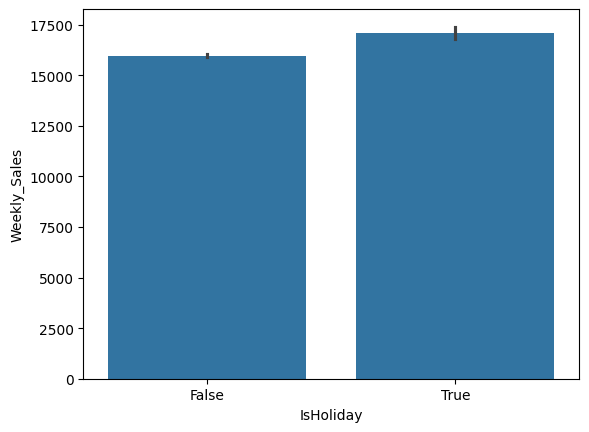

In [ ]:
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=df)

In [ ]:
df_holiday = df.loc[df['IsHoliday']==True]
df_holiday['Date'].unique()

array(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31',
       '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30',
       '2012-02-10', '2012-09-07'], dtype=object)

In [ ]:
df_not_holiday = df.loc[df['IsHoliday']==False]
df_not_holiday['Date'].nunique()

133

All holidays are not in the data. There are 4 holiday values such as;

Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13

Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13

Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13

Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13


After the 07-Sep-2012 holidays are in test set for prediction. When we look at the data, average weekly sales for holidays are significantly higher than not-holiday days. In train data, there are 133 weeks for non-holiday and 10 weeks for holiday.

I want to see differences between holiday types. So, I create new columns for 4 types of holidays and fill them with boolean values. If date belongs to this type of holiday it is True, if not False.

In [ ]:
# Super bowl dates in train set
df.loc[(df['Date'] == '2010-02-12')|(df['Date'] == '2011-02-11')|(df['Date'] == '2012-02-10'),'Super_Bowl'] = True
df.loc[(df['Date'] != '2010-02-12')&(df['Date'] != '2011-02-11')&(df['Date'] != '2012-02-10'),'Super_Bowl'] = False

In [ ]:
# Labor day dates in train set
df.loc[(df['Date'] == '2010-09-10')|(df['Date'] == '2011-09-09')|(df['Date'] == '2012-09-07'),'Labor_Day'] = True
df.loc[(df['Date'] != '2010-09-10')&(df['Date'] != '2011-09-09')&(df['Date'] != '2012-09-07'),'Labor_Day'] = False

In [ ]:
# Thanksgiving dates in train set
df.loc[(df['Date'] == '2010-11-26')|(df['Date'] == '2011-11-25'),'Thanksgiving'] = True
df.loc[(df['Date'] != '2010-11-26')&(df['Date'] != '2011-11-25'),'Thanksgiving'] = False

In [ ]:
#Christmas dates in train set
df.loc[(df['Date'] == '2010-12-31')|(df['Date'] == '2011-12-30'),'Christmas'] = True
df.loc[(df['Date'] != '2010-12-31')&(df['Date'] != '2011-12-30'),'Christmas'] = False

<Axes: xlabel='Christmas', ylabel='Weekly_Sales'>

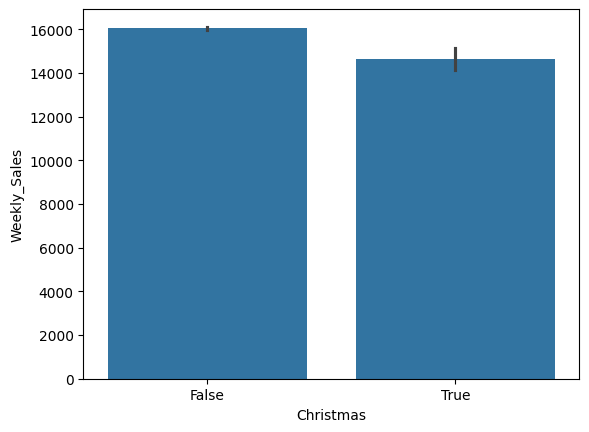

In [ ]:
sns.barplot(x='Christmas', y='Weekly_Sales', data=df) # Christmas holiday vs not-Christmas

<Axes: xlabel='Thanksgiving', ylabel='Weekly_Sales'>

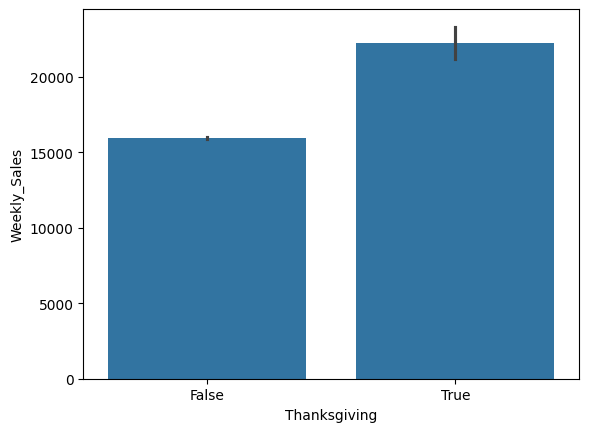

In [ ]:
sns.barplot(x='Thanksgiving', y='Weekly_Sales', data=df) # Thanksgiving holiday vs not-thanksgiving

<Axes: xlabel='Super_Bowl', ylabel='Weekly_Sales'>

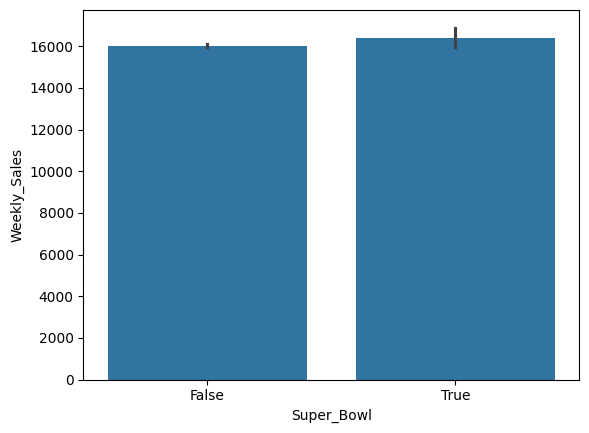

In [ ]:
sns.barplot(x='Super_Bowl', y='Weekly_Sales', data=df) # Super bowl holiday vs not-super bowl

<Axes: xlabel='Labor_Day', ylabel='Weekly_Sales'>

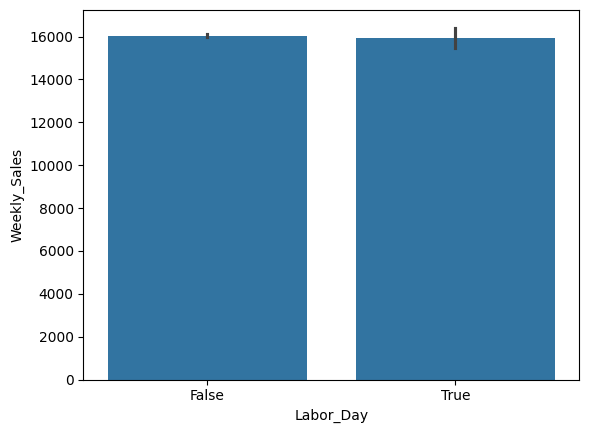

In [ ]:
sns.barplot(x='Labor_Day', y='Weekly_Sales', data=df) # Labor day holiday vs not-labor day

It is shown that for the graphs, Labor Day and Christmas do not increase weekly average sales. There is positive effect on sales in Super bowl, but the highest difference is in the Thanksgiving. I think, people generally prefer to buy Christmas gifts 1-2 weeks before Christmas, so it does not change sales in the Christmas week. And, there is Black Friday sales in the Thanksgiving week.

# Type Effect on Holidays

There are three different store types in the data as A, B and C.

In [ ]:
df.groupby(['Christmas','Type'])['Weekly_Sales'].mean()  # Avg weekly sales for types on Christmas

Christmas  Type
False      A       20174.350209
           B       12301.986116
           C        9570.951973
True       A       18310.167535
           B       11488.988057
           C        8031.520607
Name: Weekly_Sales, dtype: float64

In [ ]:
df.groupby(['Labor_Day','Type'])['Weekly_Sales'].mean()

Labor_Day  Type
False      A       20151.210941
           B       12294.954138
           C        9542.098293
True       A       20004.267422
           B       12084.304642
           C        9893.459258
Name: Weekly_Sales, dtype: float64

In [ ]:
df.groupby(['Thanksgiving','Type'])['Weekly_Sales'].mean()

Thanksgiving  Type
False         A       20044.007801
              B       12197.717405
              C        9547.377807
True          A       27397.776346
              B       18733.973971
              C        9696.566616
Name: Weekly_Sales, dtype: float64

In [ ]:
df.groupby(['Super_Bowl','Type'])['Weekly_Sales'].mean()

Super_Bowl  Type
False       A       20138.055908
            B       12286.739293
            C        9536.110508
True        A       20612.757674
            B       12467.035506
            C       10179.271884
Name: Weekly_Sales, dtype: float64

I want to see percentages of store types.

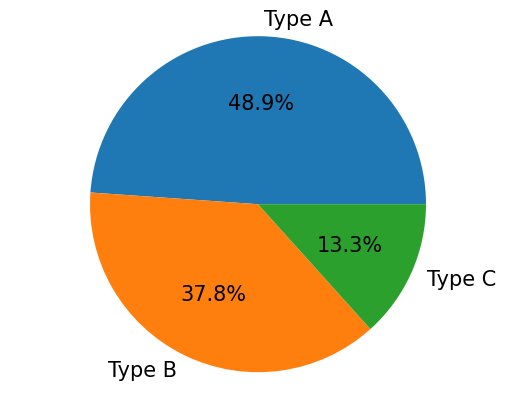

In [ ]:
my_data = [48.88, 37.77 , 13.33 ]
my_labels = 'Type A','Type B', 'Type C'
plt.pie(my_data,labels=my_labels,autopct='%1.1f%%', textprops={'fontsize': 15}) #plot pie type and bigger the labels
plt.axis('equal')
mpl.rcParams.update({'font.size': 20}) #bigger percentage labels

plt.show()

In [ ]:
df.groupby('IsHoliday')['Weekly_Sales'].mean()

,Weekly_Sales
IsHoliday,
False,15952.816352
True,17094.300918


Nearly, half of the stores are belongs to Type A.

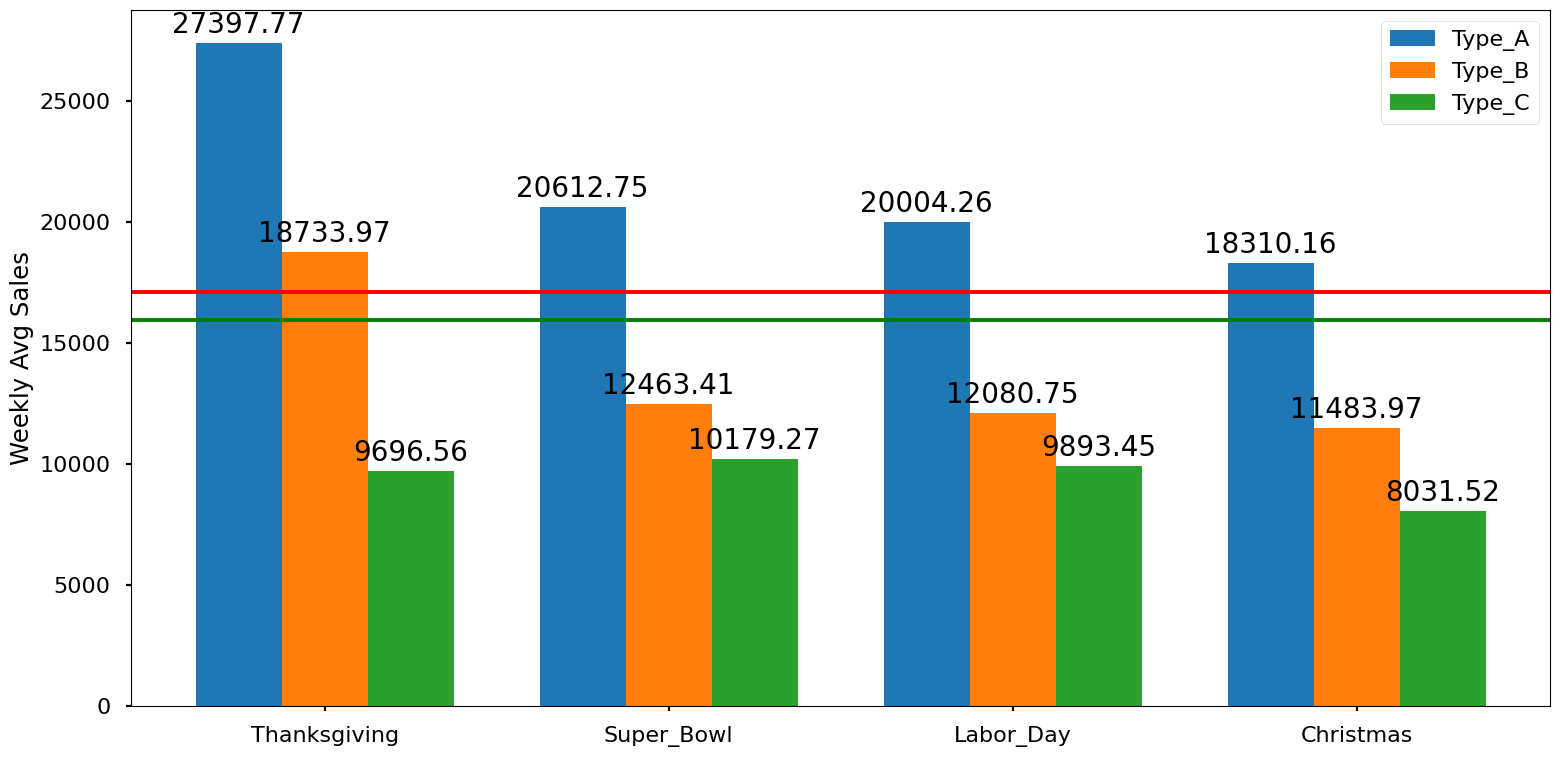

In [ ]:
# Plotting avg wekkly sales according to holidays by types
plt.style.use('seaborn-poster')
labels = ['Thanksgiving', 'Super_Bowl', 'Labor_Day', 'Christmas']
A_means = [27397.77, 20612.75, 20004.26, 18310.16]
B_means = [18733.97, 12463.41, 12080.75, 11483.97]
C_means = [9696.56,10179.27,9893.45,8031.52]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x - width, A_means, width, label='Type_A')
rects2 = ax.bar(x , B_means, width, label='Type_B')
rects3 = ax.bar(x + width, C_means, width, label='Type_C')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Weekly Avg Sales')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.axhline(y=17094.30,color='r') # holidays avg
plt.axhline(y=15952.82,color='green') # not-holiday avg

fig.tight_layout()

plt.show()

It is seen from the graph that, highest sale average is in the Thanksgiving week between holidays. And, for all holidays Type A stores has highest sales.

In [ ]:
df.sort_values(by='Weekly_Sales',ascending=False).head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas
90645,10,72,2010-11-26,693099.36,True,55.33,3.162,NaN,NaN,NaN,NaN,NaN,126.669267,9.003,B,126512,False,False,True,False
337053,35,72,2011-11-25,649770.18,True,47.88,3.492,1333.24,NaN,58563.24,20.97,6386.86,140.421786,8.745,B,103681,False,False,True,False
94393,10,72,2011-11-25,630999.19,True,60.68,3.760,174.72,329.0,141630.61,79.00,1009.98,129.836400,7.874,B,126512,False,False,True,False
333594,35,72,2010-11-26,627962.93,True,46.67,3.039,NaN,NaN,NaN,NaN,NaN,136.689571,8.763,B,103681,False,False,True,False
131088,14,72,2010-11-26,474330.10,True,46.15,3.039,NaN,NaN,NaN,NaN,NaN,182.783277,8.724,A,200898,False,False,True,False


Also, it is not surprise that top 5 highest weekly sales are belongs to Thanksgiving weeks.

# To See the Size - Type Relation

In [ ]:
df_store.groupby('Type').describe()['Size'].round(2) # See the Size-Type relation

,count,mean,std,min,25%,50%,75%,max
Type,,,,,,,,
A,22.0,177247.73,49392.62,39690.0,155840.75,202406.0,203819.0,219622.0
B,17.0,101190.71,32371.14,34875.0,93188.00,114533.0,123737.0,140167.0
C,6.0,40541.67,1304.15,39690.0,39745.00,39910.0,40774.0,42988.0


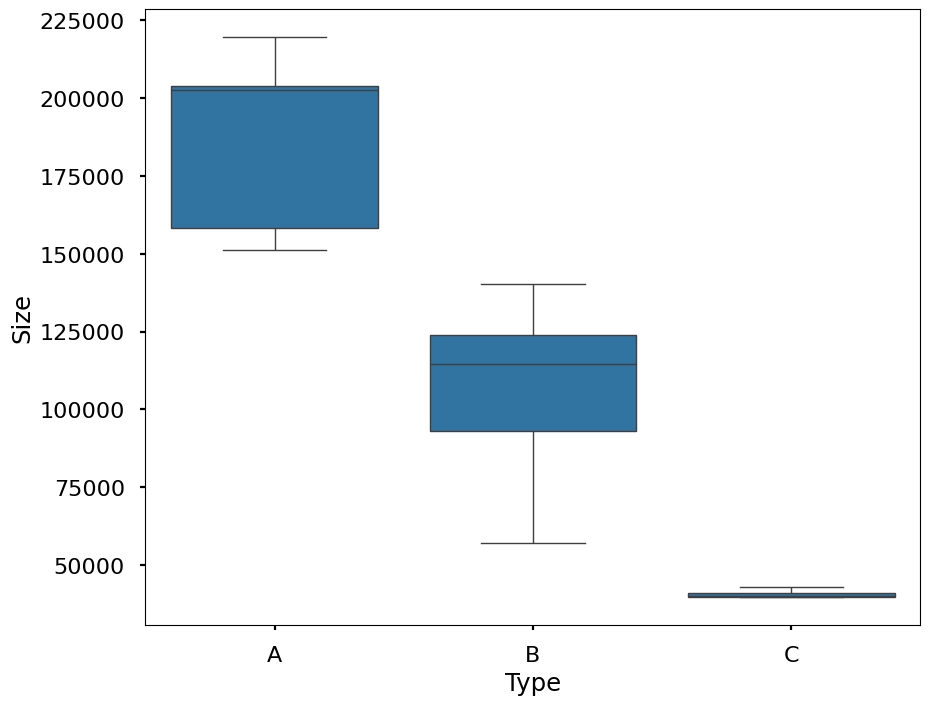

In [ ]:
plt.figure(figsize=(10,8)) # To see the type-size relation
fig = sns.boxplot(x='Type', y='Size', data=df, showfliers=False)

Size of the type of stores are consistent with sales, as expected. Higher size stores has higher sales. And, Walmart classify stores according to their sizes according to graph. After the smallest size value of Type A, Type B begins. After the smallest size value of Type B, Type C begins.

# Markdown Columns

Walmart gave markdown columns to see the effect if markdowns on sales. When I check columns, there are many NaN values for markdowns. I decided to change them with 0, because if there is markdown in the row, it is shown with numbres. So, if I can write 0, it shows there is no markdown at that date.

In [ ]:
df.isna().sum()

,0
Store,0
Dept,0
Date,0
Weekly_Sales,0
IsHoliday,0
Temperature,0
Fuel_Price,0
MarkDown1,270031
MarkDown2,309308
MarkDown3,283561


In [ ]:
df = df.fillna(0) # filling null's with 0

In [ ]:
df.isna().sum() # last null check

,0
Store,0
Dept,0
Date,0
Weekly_Sales,0
IsHoliday,0
Temperature,0
Fuel_Price,0
MarkDown1,0
MarkDown2,0
MarkDown3,0


In [ ]:
df.describe() # to see weird statistical things

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000,420212.000000
mean,22.195611,44.241309,16033.114591,60.090599,3.360890,2590.323565,878.905242,468.845949,1083.534361,1662.805002,171.212496,7.960000,136749.732787
std,12.787236,30.508819,22729.492116,18.447857,0.458519,6053.415601,5076.928566,5534.069859,3896.068938,4206.209357,39.162445,1.863879,60993.084568
min,1.000000,1.000000,0.010000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2120.130000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7661.700000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.350989,7.866000,140167.000000
75%,33.000000,74.000000,20271.265000,74.280000,3.738000,2809.050000,2.400000,4.540000,425.290000,2168.040000,212.445487,8.567000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


Minimum value for weekly sales is 0.01. Most probably, this value is not true but I prefer not to change them now. Because, there are many departments and many stores. It takes too much time to check each department for each store (45 store for 81 departments). So, I take averages for EDA.

# Deeper Look in Sales

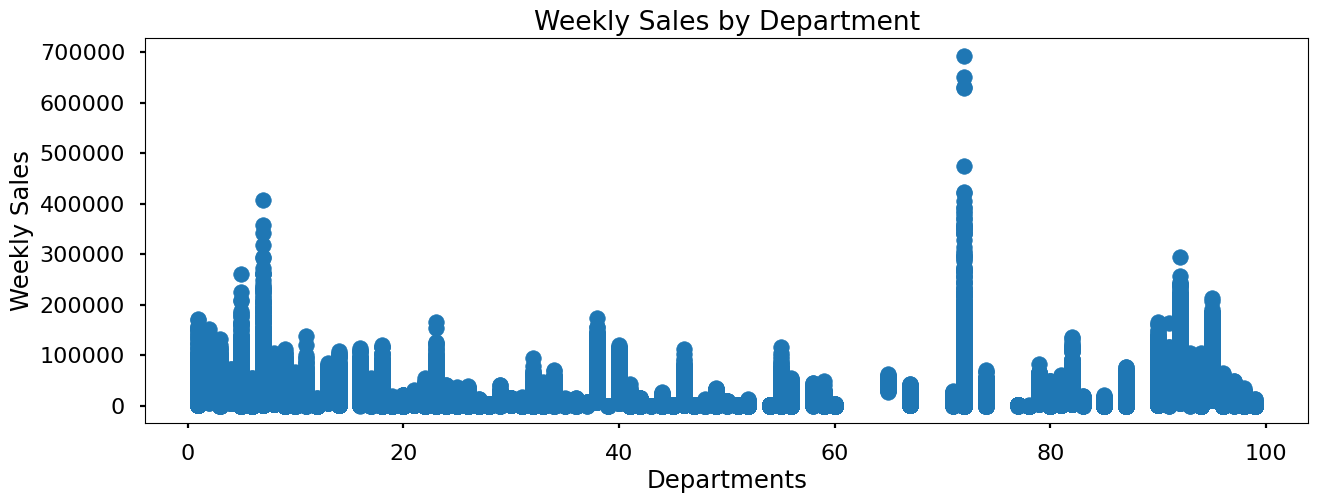

In [ ]:
x = df['Dept']
y = df['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Department')
plt.xlabel('Departments')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

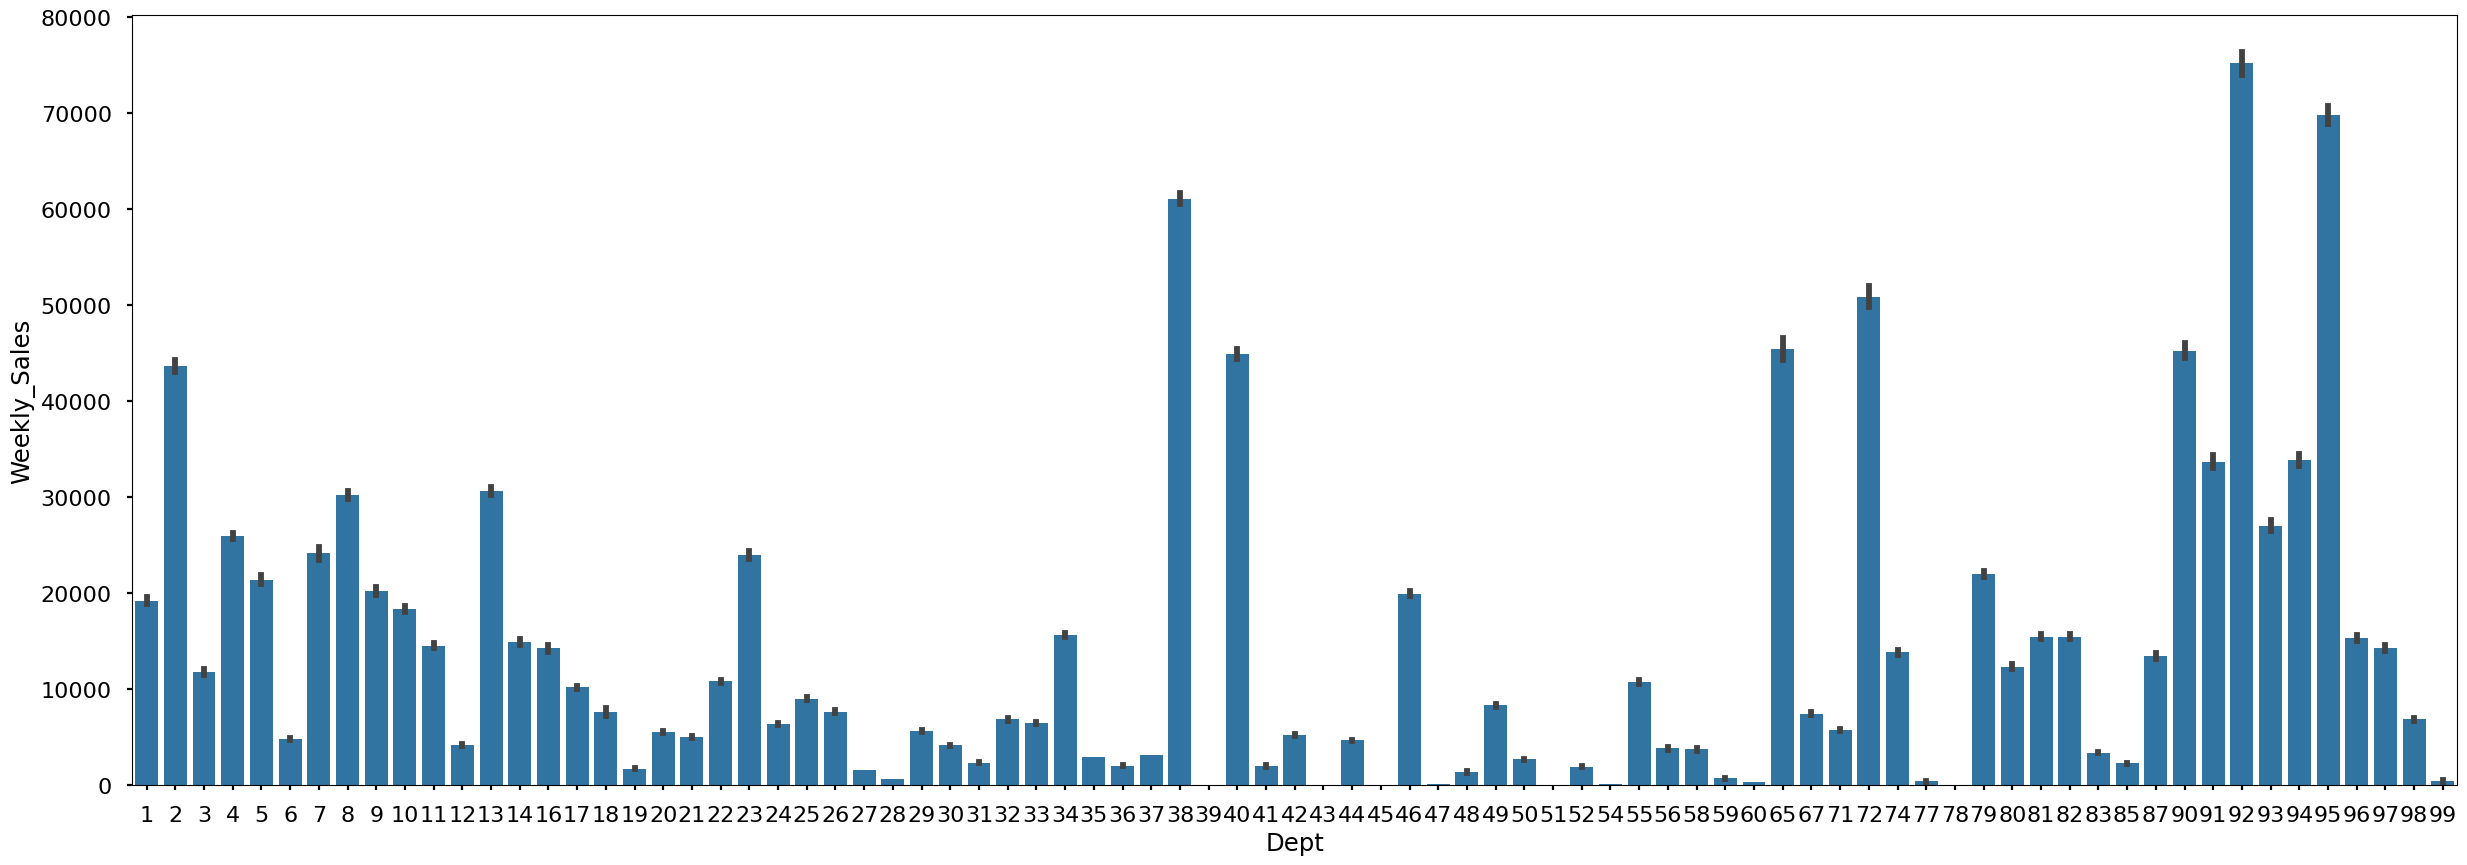

In [ ]:
plt.figure(figsize=(30,10))
fig = sns.barplot(x='Dept', y='Weekly_Sales', data=df)

From the first graph, it is seen that one department between 60-80(I assume it is 72), has higher sales values. But, when we take the averages, it is seen that department 92 has higher mean sales. Department 72 is seasonal department, I think. It has higher values is some seasons but on average 92 is higher.

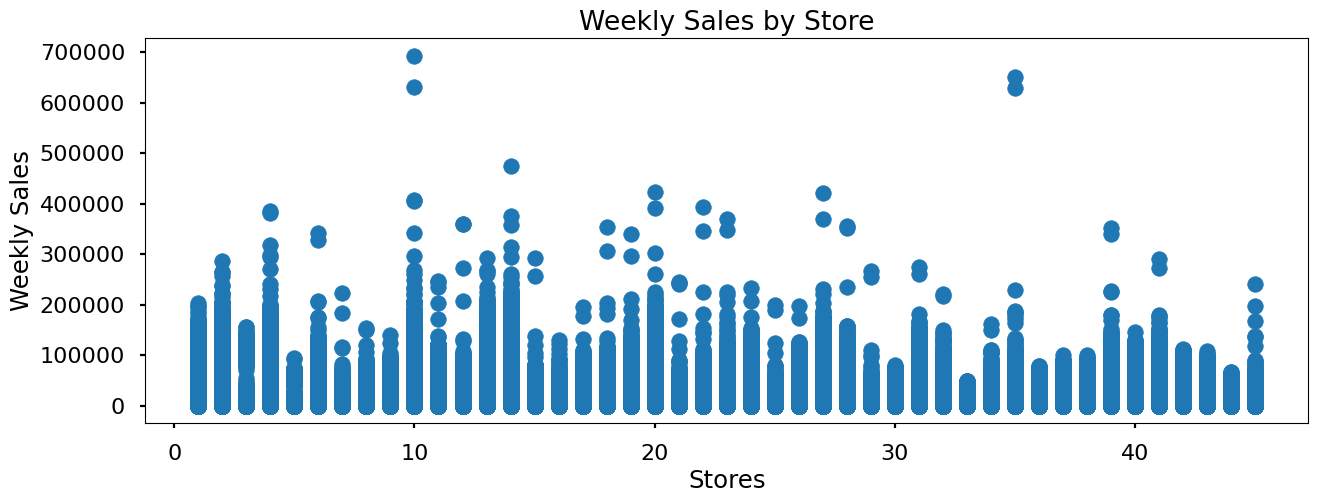

In [ ]:
x = df['Store']
y = df['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Store')
plt.xlabel('Stores')
plt.ylabel('Weekly Sales')
plt.scatter(x,y)
plt.show()

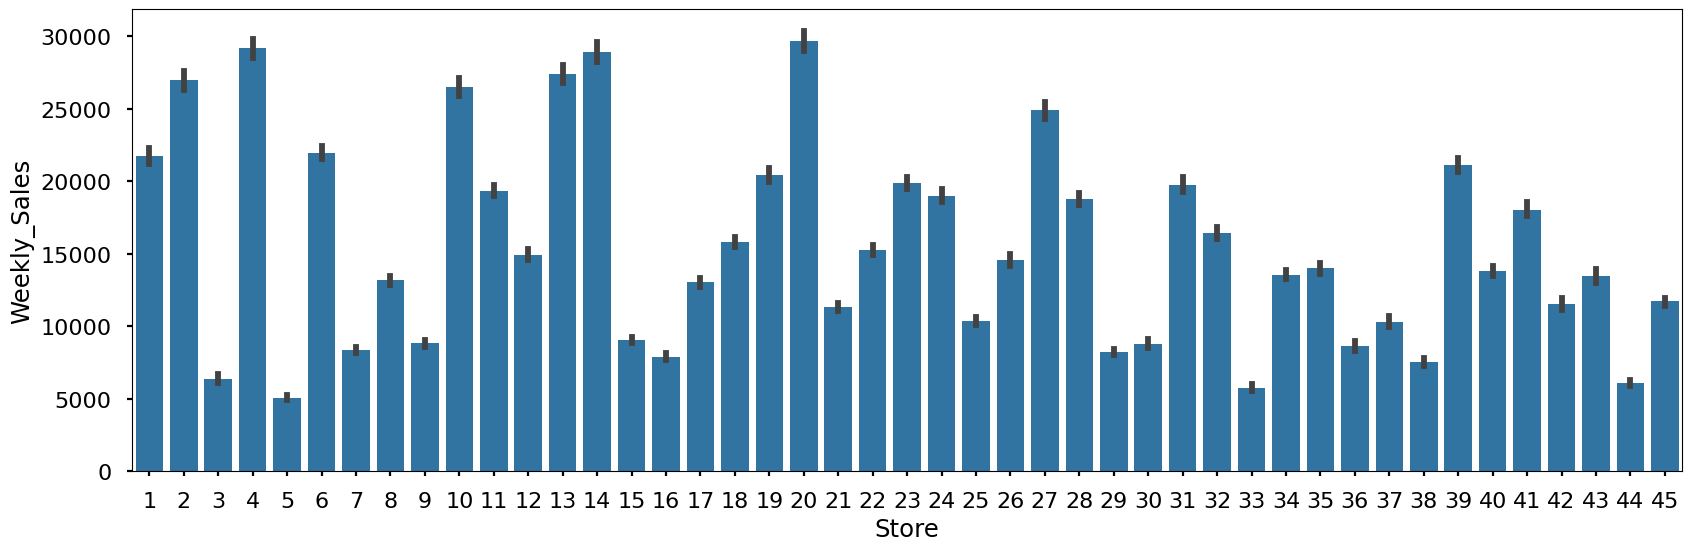

In [ ]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='Store', y='Weekly_Sales', data=df)

Same thing happens in stores. From the first graph, some stores has higher sales but on average store 20 is the best and 4 and 14 following it.

# Changing Date to Datetime and Creating New Columns

In [ ]:
!pip install pandas
import pandas as pd

# Print the first few rows of the 'df' DataFrame
print(df.head())

# Check the data type of the 'Date' column
print(df['Date'].dtype)

# Convert the 'Date' column to datetime format
df["Date"] = pd.to_datetime(df["Date"])

# Print the first few rows of the 'df' DataFrame again
print(df.head())

# Check the data type of the 'Date' column again
print(df['Date'].dtype)

# Extract the week, month, and year from the 'Date' column
df['week'] =df['Date'].dt.isocalendar().week
df['month'] =df['Date'].dt.month
df['year'] =df['Date'].dt.year

# Print the first few rows of the 'df' DataFrame one last time
print(df.head())

   Store  Dept        Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0      1     1  2010-02-05      24924.50      False        42.31       2.572   
1      1     2  2010-02-05      50605.27      False        42.31       2.572   
2      1     3  2010-02-05      13740.12      False        42.31       2.572   
3      1     4  2010-02-05      39954.04      False        42.31       2.572   
4      1     5  2010-02-05      32229.38      False        42.31       2.572   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        0.0        0.0        0.0        0.0        0.0  211.096358   
1        0.0        0.0        0.0        0.0        0.0  211.096358   
2        0.0        0.0        0.0        0.0        0.0  211.096358   
3        0.0        0.0        0.0        0.0        0.0  211.096358   
4        0.0        0.0        0.0        0.0        0.0  211.096358   

   Unemployment Type    Size  Super_Bowl  Labor_Day  Thanksgiving  Christmas  
0      

In [ ]:
df.groupby('month')['Weekly_Sales'].mean() # to see the best months for sales

,Weekly_Sales
month,
1,14182.239153
2,16048.701191
3,15464.817698
4,15696.435193
5,15845.556200
6,16397.605478
7,15905.472425
8,16113.800069
9,15147.216063


In [ ]:
df.groupby('year')['Weekly_Sales'].mean() # to see the best years for sales

,Weekly_Sales
year,
2010,16318.648285
2011,16007.797985
2012,15748.265005


<Axes: xlabel='month'>

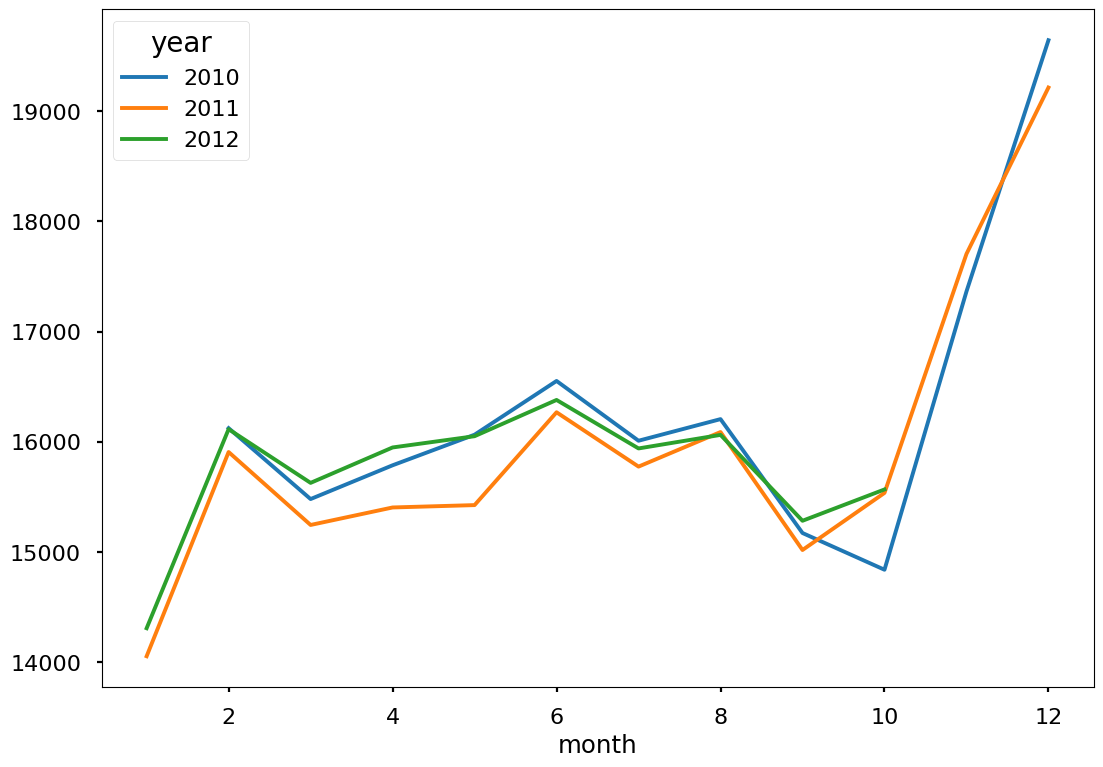

In [ ]:
monthly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "month")
monthly_sales.plot()

From the graph, it is seen that 2011 has lower sales than 2010 generally. When we look at the mean sales it is seen that 2010 has higher values, but 2012 has no information about November and December which have higher sales. Despite of 2012 has no last two months sales, it's mean is near to 2010. Most probably, it will take the first place if we get 2012 results and add them.

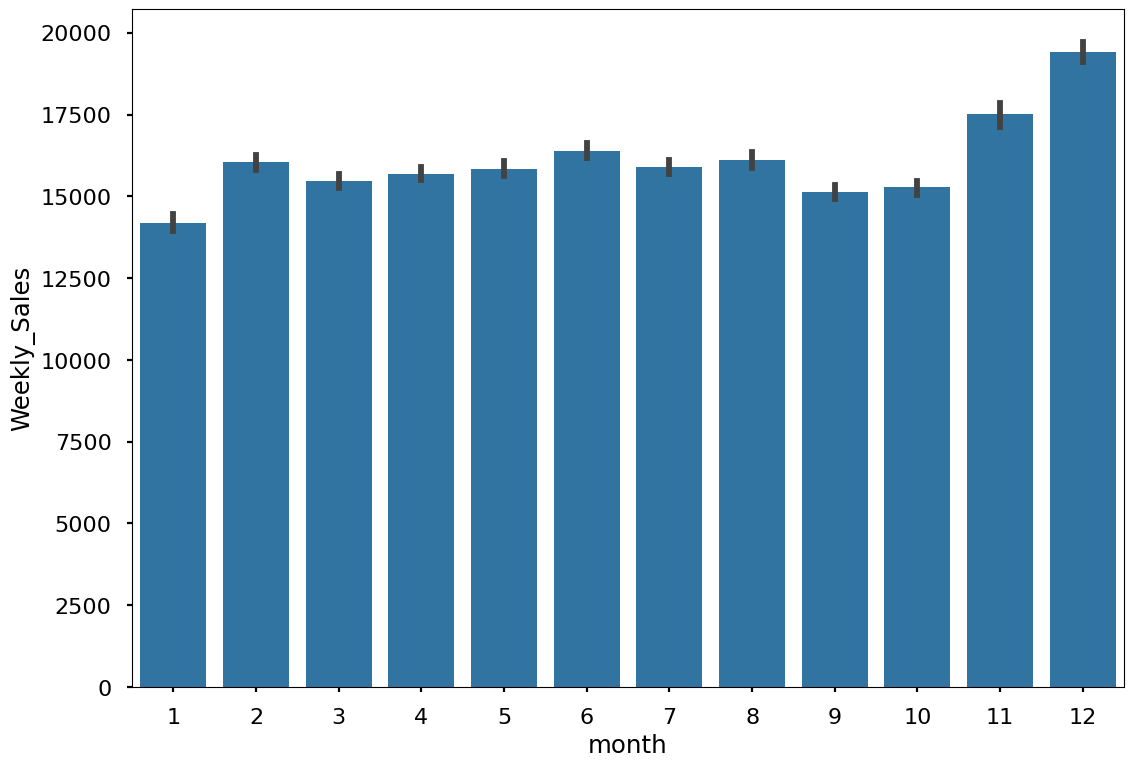

In [ ]:
fig = sns.barplot(x='month', y='Weekly_Sales', data=df)

When we look at the graph above, the best sales are in December and November, as expected. The highest values are belongs to Thankgiving holiday but when we take average it is obvious that December has the best value.

In [ ]:
df.groupby('week')['Weekly_Sales'].mean().sort_values(ascending=False).head()

,Weekly_Sales
week,
51,26454.164116
47,22269.601768
50,20478.421134
49,18731.794840
22,16856.650245


Top 5 sales averages by weekly belongs to 1-2 weeks before Christmas, Thanksgiving, Black Friday and end of May, when the schools are closed.

<Axes: xlabel='week'>

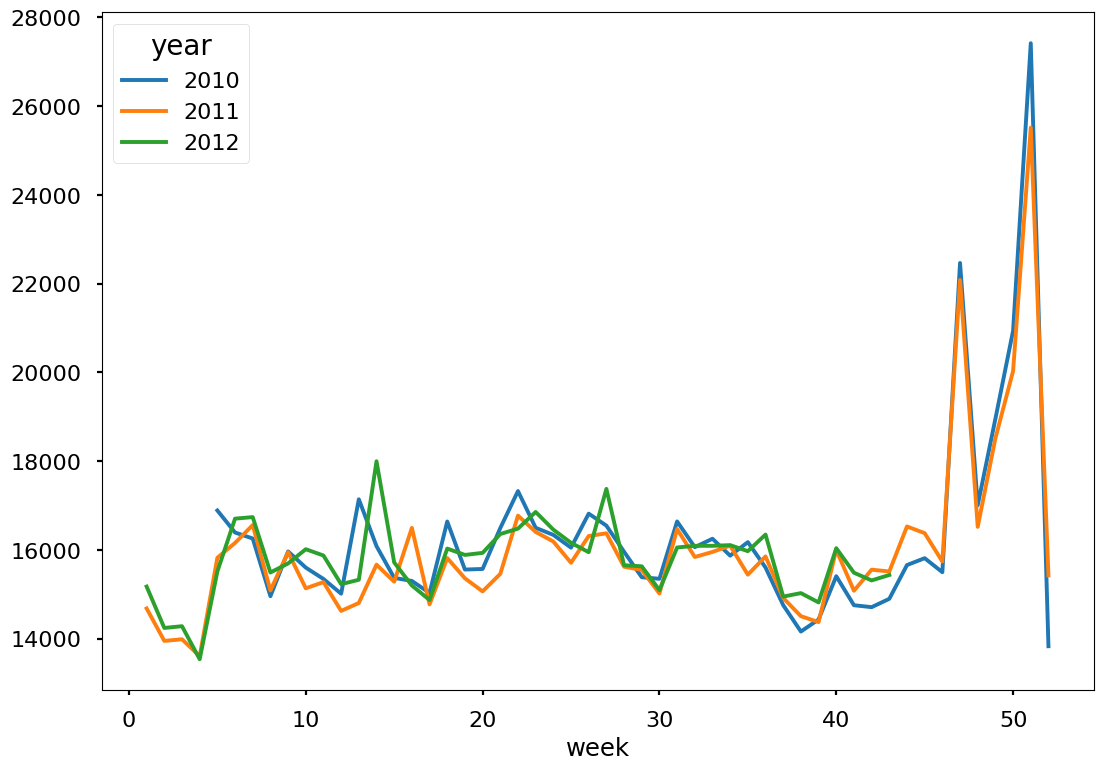

In [ ]:
weekly_sales = pd.pivot_table(df, values = "Weekly_Sales", columns = "year", index = "week")
weekly_sales.plot()

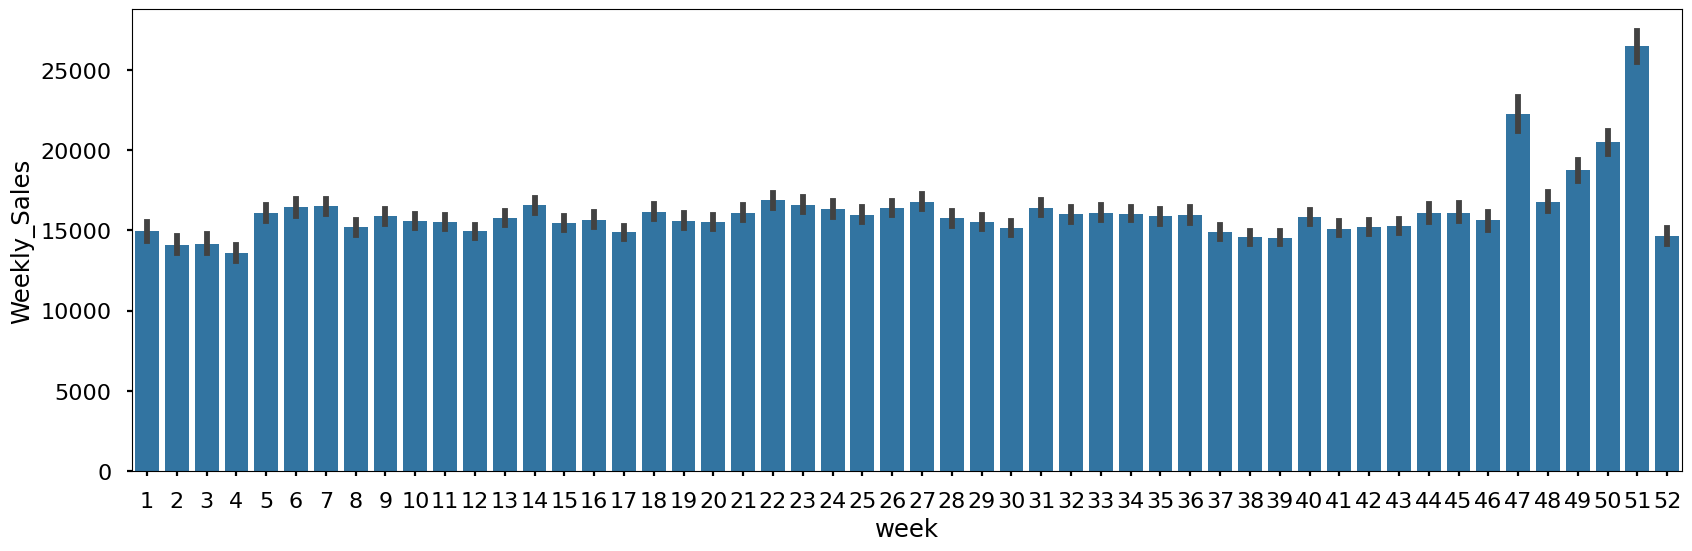

In [ ]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='week', y='Weekly_Sales', data=df)

From graphs, it is seen that 51th week and 47th weeks have significantly higher averages as Christmas, Thankgiving and Black Friday effects.

# Fuel Price, CPI , Unemployment , Temperature Effects

<Axes: xlabel='Fuel_Price'>

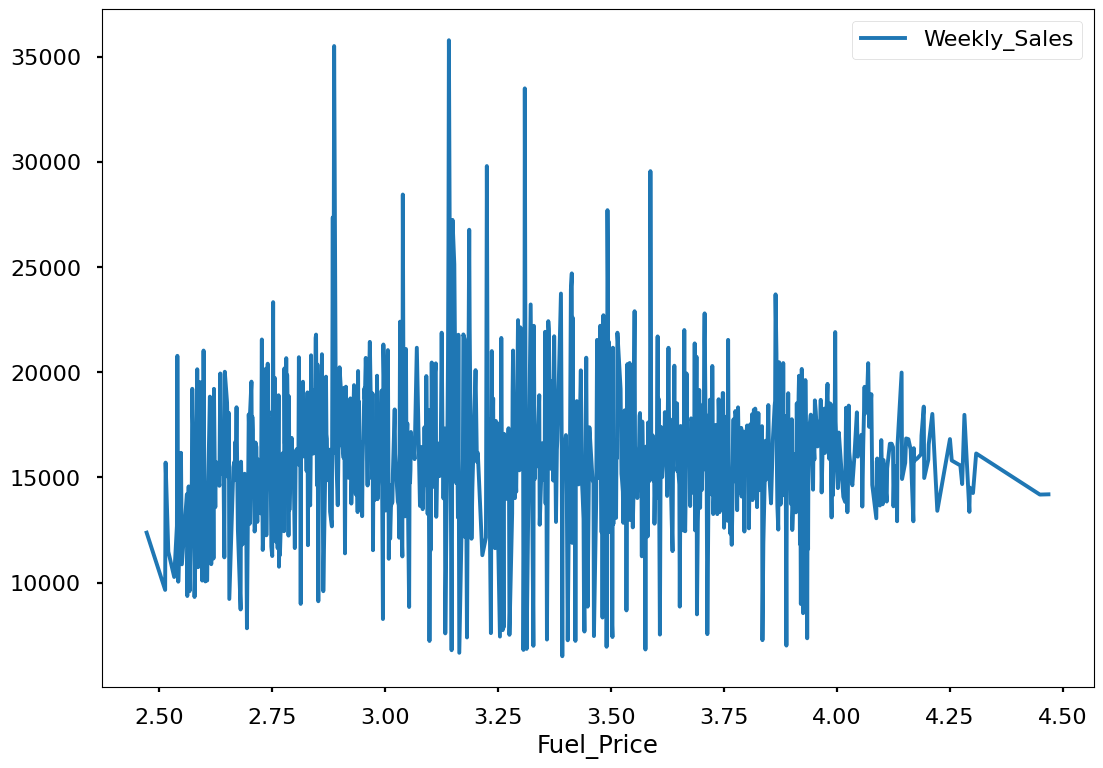

In [ ]:
fuel_price = pd.pivot_table(df, values = "Weekly_Sales", index= "Fuel_Price")
fuel_price.plot()

<Axes: xlabel='Temperature'>

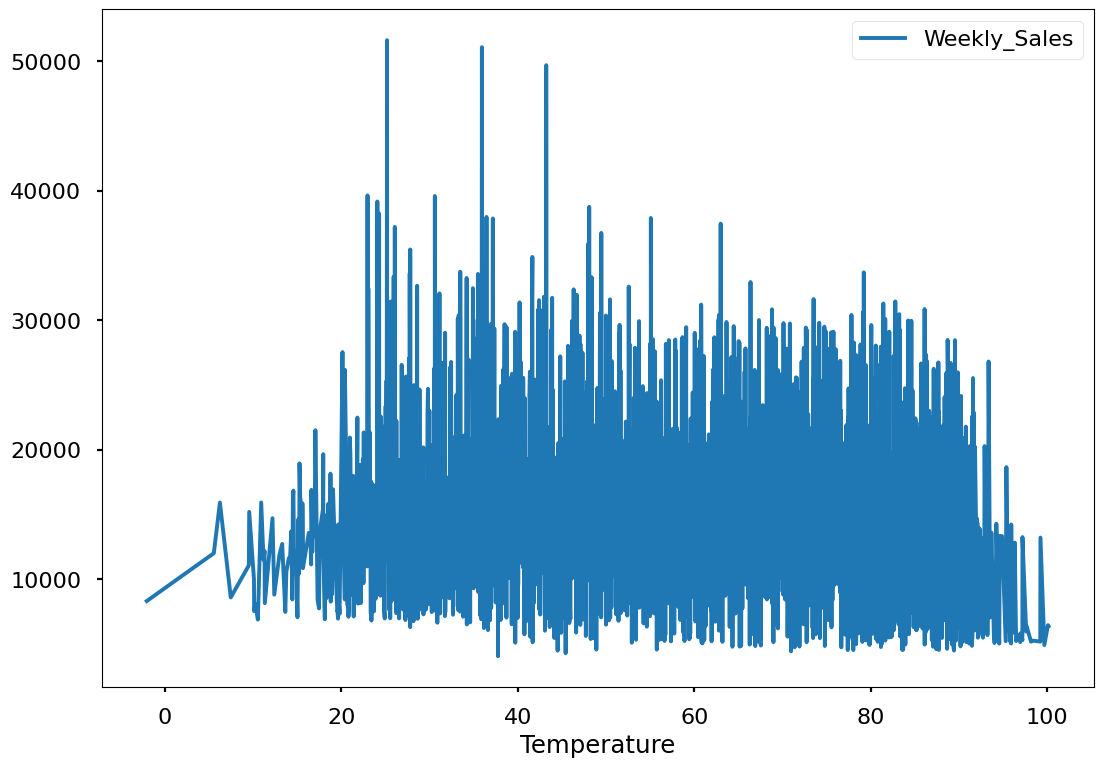

In [ ]:
temp = pd.pivot_table(df, values = "Weekly_Sales", index= "Temperature")
temp.plot()

<Axes: xlabel='CPI'>

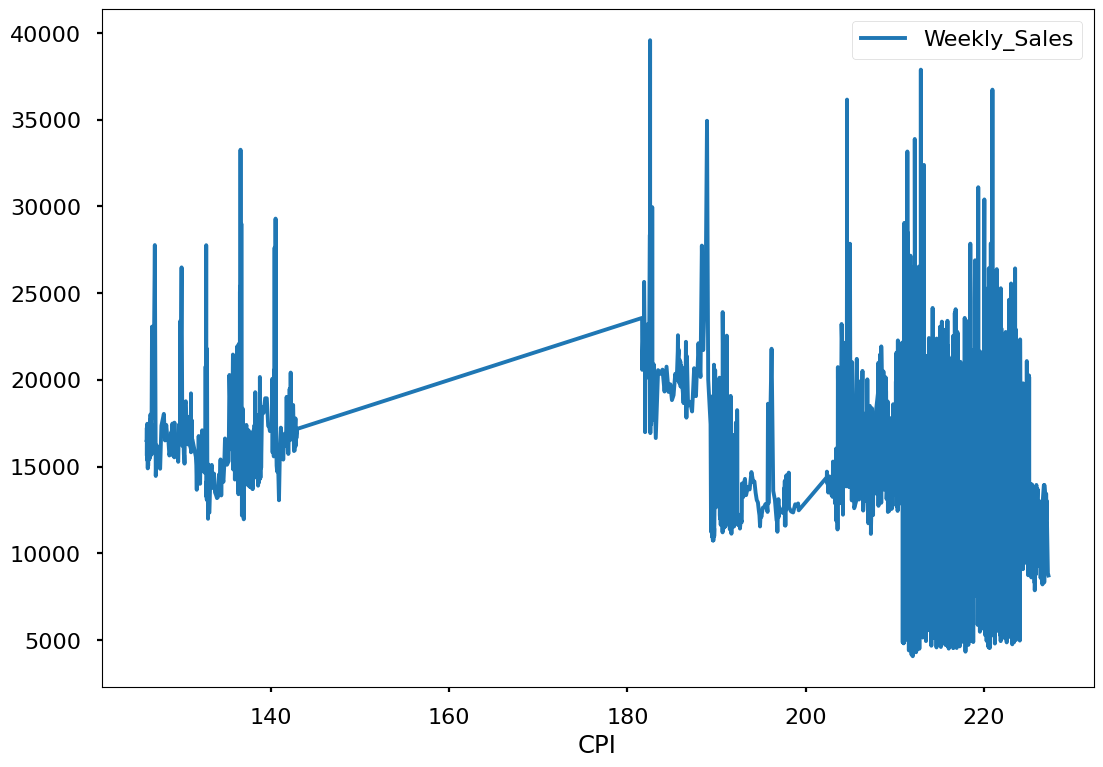

In [ ]:
CPI = pd.pivot_table(df, values = "Weekly_Sales", index= "CPI")
CPI.plot()

<Axes: xlabel='Unemployment'>

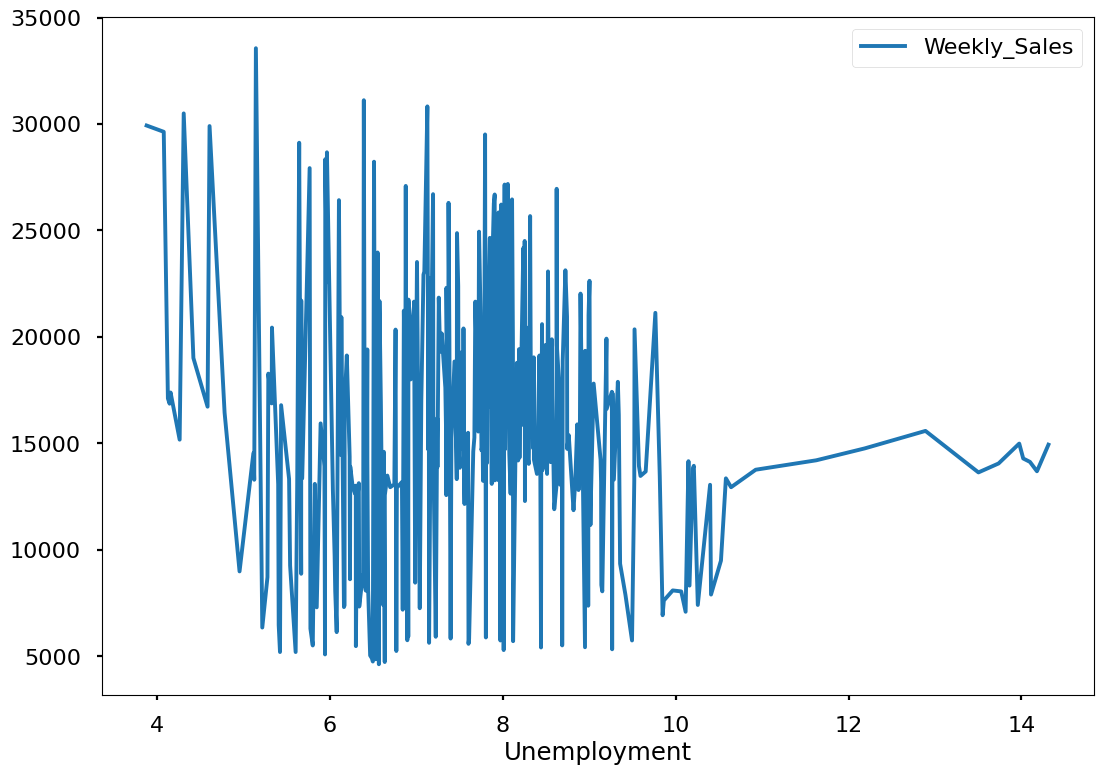

In [ ]:
unemployment = pd.pivot_table(df, values = "Weekly_Sales", index= "Unemployment")
unemployment.plot()

From graphs, it is seen that there are no significant patterns between CPI, temperature, unemployment rate, fuel price vs weekly sales. There is no data for CPI between 140-180 also.

In [ ]:
df.to_csv('clean_data.csv') # assign new data frame to csv for using after here

# Findings and Explorations

# Cleaning Process

In [ ]:
pd.options.display.max_columns=100 # to see columns

In [ ]:
df = pd.read_csv('./clean_data.csv')

In [ ]:
df.drop(columns=['Unnamed: 0'],inplace=True)

In [ ]:
df['Date'] = pd.to_datetime(df['Date']) # changing datetime to divide if needs

# Encoding the Data

For preprocessing our data, I will change holidays boolean values to 0-1 and replace type of the stores from A, B, C to 1, 2, 3.

In [ ]:
df_encoded = df.copy() # to keep original dataframe taking copy of it

In [ ]:
type_group = {'A':1, 'B': 2, 'C': 3}  # changing A,B,C to 1-2-3
df_encoded['Type'] = df_encoded['Type'].replace(type_group)

In [ ]:
df_encoded['Super_Bowl'] = df_encoded['Super_Bowl'].astype(bool).astype(int) # changing T,F to 0-1

In [ ]:
df_encoded['Thanksgiving'] = df_encoded['Thanksgiving'].astype(bool).astype(int) # changing T,F to 0-1

In [ ]:
df_encoded['Labor_Day'] = df_encoded['Labor_Day'].astype(bool).astype(int) # changing T,F to 0-1

In [ ]:
df_encoded['Christmas'] = df_encoded['Christmas'].astype(bool).astype(int) # changing T,F to 0-1

In [ ]:
df_encoded['IsHoliday'] = df_encoded['IsHoliday'].astype(bool).astype(int) # changing T,F to 0-1

In [ ]:
df_new = df_encoded.copy() # taking the copy of encoded df to keep it original

# Observation of Interactions between Features

Firstly, i will drop divided holiday columns from my data and try without them. To keep my encoded data safe, I assigned my dataframe to new one and I will use for this.

In [ ]:
drop_col = ['Super_Bowl','Labor_Day','Thanksgiving','Christmas']
df_new.drop(drop_col, axis=1, inplace=True) # dropping columns

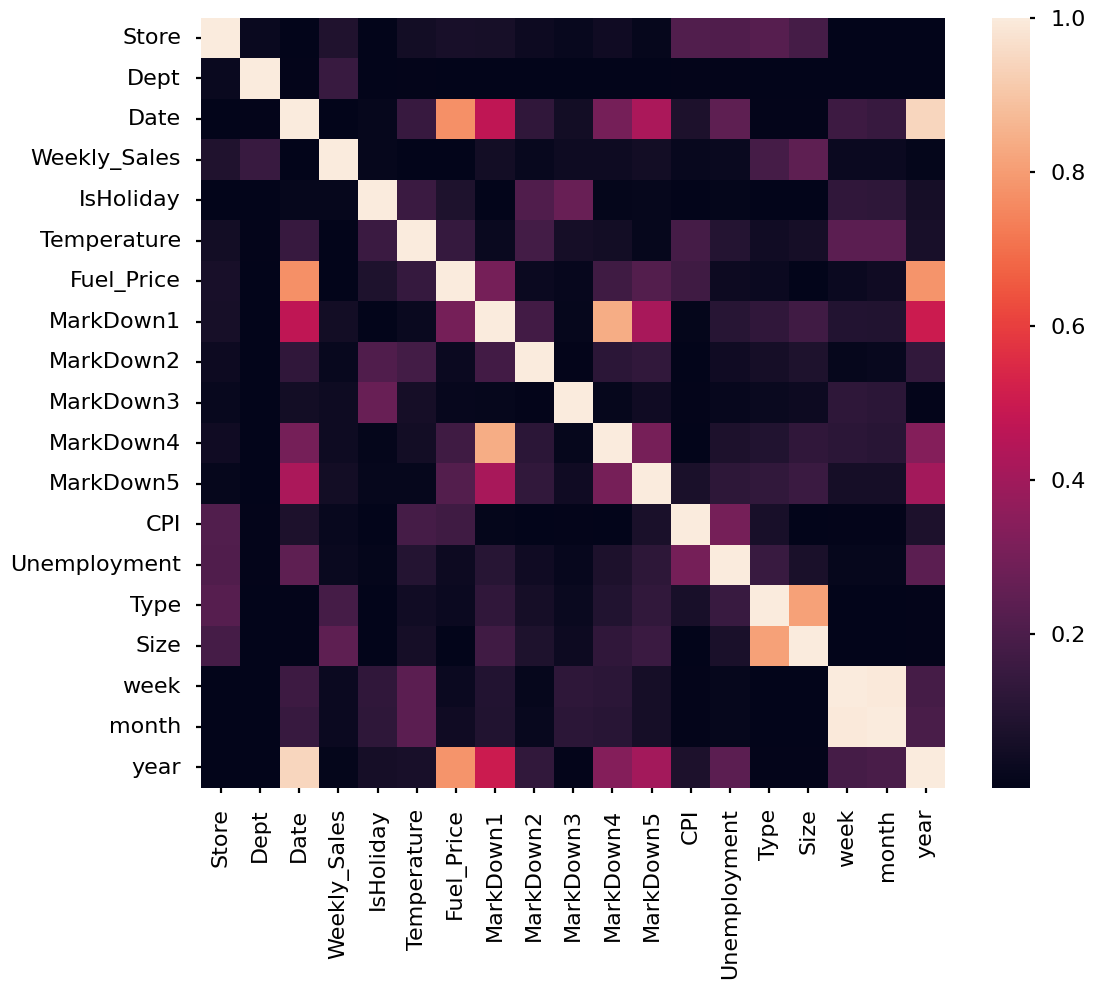

In [ ]:
plt.figure(figsize = (12,10))
sns.heatmap(df_new.corr().abs())    # To see the correlations
plt.show()

Temperature, unemployment, CPI have no significant effect on weekly sales, so I will drop them. Also, Markdown 4 and 5 highly correlated with Markdown 1. So, I will drop them also. It can create multicollinearity problem, maybe. So, first I will try without them.

In [ ]:
drop_col = ['Temperature','MarkDown4','MarkDown5','CPI','Unemployment']
df_new.drop(drop_col, axis=1, inplace=True) # dropping columns

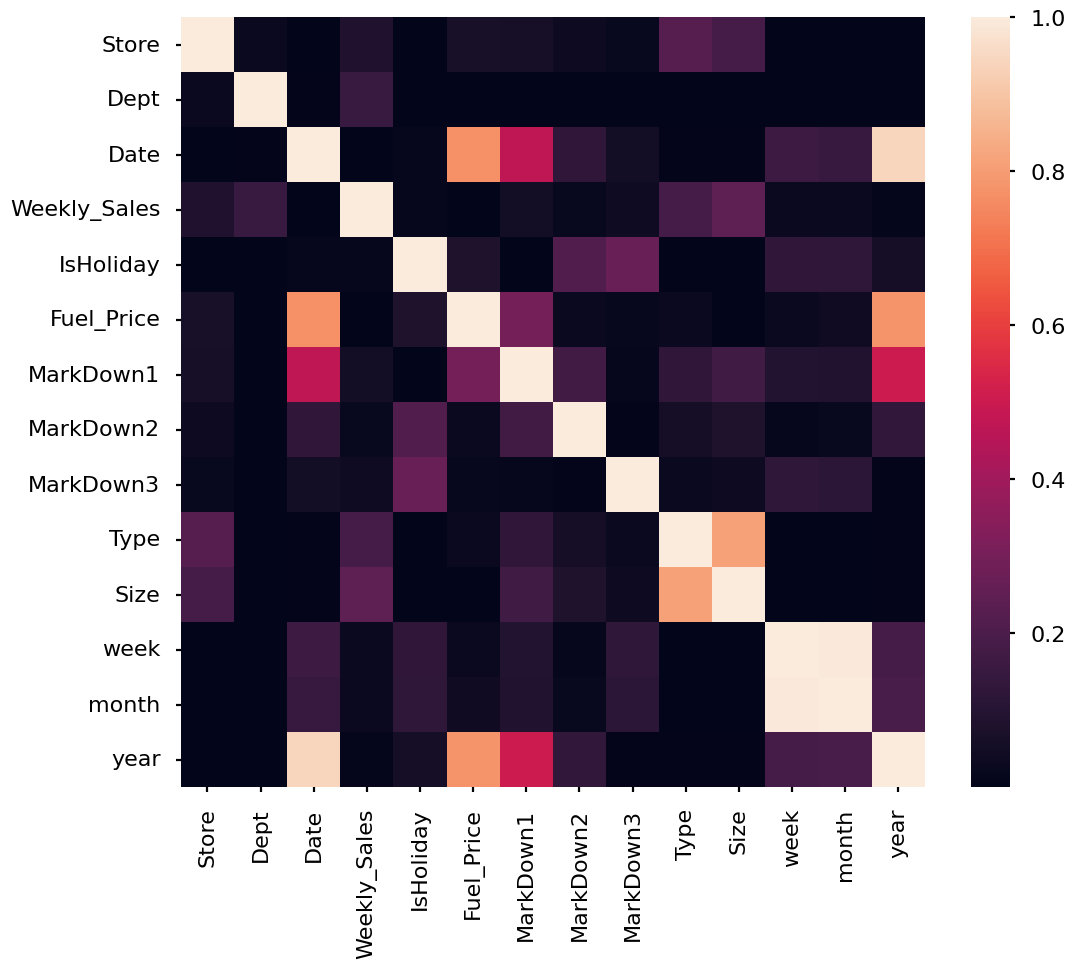

In [ ]:
plt.figure(figsize = (12,10))
sns.heatmap(df_new.corr().abs())    # To see the correlations without dropping columns
plt.show()

Size and type are highly correlated with weekly sales. Also, department and store are correlated with sales.

In [ ]:
df_new = df_new.sort_values(by='Date', ascending=True) # sorting according to date

# Creating Train-Test Splits

Our date column has continuos values, to keep the date features continue, I will not take random splitting. so, I split data manually according to 70%.

In [ ]:
train_data = df_new[:int(0.7*(len(df_new)))] # taking train part
test_data = df_new[int(0.7*(len(df_new))):] # taking test part

target = "Weekly_Sales"
used_cols = [c for c in df_new.columns.to_list() if c not in [target]] # all columns except weekly sales

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

In [ ]:
X = df_new[used_cols] # to keep train and test X values together

We have enough information in our date such as week of the year. So, I drop date columns.

In [ ]:
X_train = X_train.drop(['Date'], axis=1) # dropping date from train
X_test = X_test.drop(['Date'], axis=1) # dropping date from test

# Metric Definition Function

Our metric is not calculated as default from ready models. It is weighed error so, I will use function below to calculate it.

In [ ]:
def wmae_test(test, pred): # WMAE for test
    weights = X_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
    error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
    return error

In [ ]:
import numpy as np      # To use np.arrays
import pandas as pd     # To use dataframes
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score

# Load your data
df_store = pd.read_csv('storess.csv') #store data
df_train = pd.read_csv('train.csv') # train set
df_features = pd.read_csv('featuress.csv') #external information
# Your data processing steps here...

# Assuming you've processed the data and split it into X_train, X_test, y_train, y_test

# Initialize Linear Regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Calculate R-squared
r_squared = r2_score(y_test, y_pred)
print("R-squared:", r_squared)

# If needed, convert to classification problem and calculate accuracy
# For example, classify sales into two categories based on a threshold
threshold = 20000  # Example threshold
y_pred_class = (y_pred > threshold).astype(int)
y_test_class = (y_test > threshold).astype(int)

# Calculate Accuracy
accuracy = accuracy_score(y_test_class, y_pred_class)
print("Accuracy:", accuracy)


Mean Squared Error (MSE): 446166441.82149196
R-squared: 0.0889251930831566
Accuracy: 0.6722299784236578


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Initialize Linear Regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)


Mean Squared Error (MSE): 446166441.82149196


In [ ]:
from sklearn.metrics import r2_score

# Calculate R-squared
r_squared = r2_score(y_test, y_pred)
print("R-squared:", r_squared)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Calculate Accuracy
# As linear regression is a regression algorithm, it doesn't directly provide accuracy.
# Accuracy is usually calculated for classification problems, not regression.
# For regression problems, you can evaluate metrics like MSE, MAE, and R-squared.


R-squared: 0.0889251930831566
Mean Absolute Error (MAE): 14300.197134768248


In [ ]:
# Convert to classification problem (e.g., predicting if sales are above a certain threshold)
threshold = 20000  # Example threshold
y_pred_class = (y_pred > threshold).astype(int)
y_test_class = (y_test > threshold).astype(int)

# Calculate Accuracy
accuracy = accuracy_score(y_test_class, y_pred_class)
print("Accuracy:", accuracy)


Accuracy: 0.6722299784236578


In [ ]:
import lightgbm as lgb

# Initialize LightGBM model
lgb_model = lgb.LGBMRegressor()

# Fit the model on the training data
lgb_model.fit(X_train, y_train)

# Predict on the test data
y_pred_lgb = lgb_model.predict(X_test)

# Calculate Mean Absolute Error (MAE)
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)/100
print("LightGBM - Mean Absolute Error (MAE):", mae_lgb)

# Calculate Mean Squared Error (MSE)
mse_lgb = mean_squared_error(y_test, y_pred_lgb)/1000000
print("LightGBM - Mean Squared Error (MSE):", mse_lgb)

# Calculate R-squared
r_squared_lgb = r2_score(y_test, y_pred_lgb)
print("LightGBM - R-squared:", r_squared_lgb)

# If needed, convert to classification problem and calculate accuracy
# For example, classify sales into two categories based on a threshold
threshold = 20000  # Example threshold
y_pred_class_lgb = (y_pred_lgb > threshold).astype(int)
y_test_class_lgb = (y_test > threshold).astype(int)

# Calculate Accuracy
accuracy_lgb = accuracy_score(y_test_class_lgb, y_pred_class_lgb)
print("LightGBM - Accuracy:", accuracy_lgb)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1217
[LightGBM] [Info] Number of data points in the train set: 294148, number of used features: 12
[LightGBM] [Info] Start training from score 16152.408348
LightGBM - Mean Absolute Error (MAE): 40.88702785447132
LightGBM - Mean Squared Error (MSE): 42.690632681584624
LightGBM - R-squared: 0.9128254474524241
LightGBM - Accuracy: 0.9335416931082625


In [ ]:
import xgboost as xgb

# Initialize XGBoost model
xgb_model = xgb.XGBRegressor()

# Fit the model on the training data
xgb_model.fit(X_train, y_train)

# Predict on the test data
y_pred_xgb = xgb_model.predict(X_test)

# Calculate Mean Absolute Error (MAE)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print("XGBoost - Mean Absolute Error (MAE):", mae_xgb)

# Calculate Mean Squared Error (MSE)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print("XGBoost - Mean Squared Error (MSE):", mse_xgb)

# Calculate R-squared
r_squared_xgb = r2_score(y_test, y_pred_xgb)
print("XGBoost - R-squared:", r_squared_xgb)

# If needed, convert to classification problem and calculate accuracy
# For example, classify sales into two categories based on a threshold
threshold = 20000  # Example threshold
y_pred_class_xgb = (y_pred_xgb > threshold).astype(int)
y_test_class_xgb = (y_test > threshold).astype(int)

# Calculate Accuracy
accuracy_xgb = accuracy_score(y_test_class_xgb, y_pred_class_xgb)
print("XGBoost - Accuracy:", accuracy_xgb)


XGBoost - Mean Absolute Error (MAE): 3112.6740715648484
XGBoost - Mean Squared Error (MSE): 27559643.932530936
XGBoost - R-squared: 0.9437230259361965
XGBoost - Accuracy: 0.9517229343825359


In [ ]:
pip install catboost


In [ ]:
# Initialize Random Forest model
rf_model = RandomForestRegressor()

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Predict on the test data
y_pred_rf = rf_model.predict(X_test)

# Calculate Mean Absolute Error (MAE)
mae_rf = mean_absolute_error(y_test, y_pred_rf)/100
print("Random Forest - Mean Absolute Error (MAE):", mae_rf)

# Calculate Mean Squared Error (MSE)
mse_rf = mean_squared_error(y_test, y_pred_rf)/100000
print("Random Forest - Mean Squared Error (MSE):", mse_rf)

# Calculate R-squared
r_squared_rf = r2_score(y_test, y_pred_rf)
print("Random Forest - R-squared:", r_squared_rf)

# If needed, convert to classification problem and calculate accuracy
# For example, classify sales into two categories based on a threshold
threshold = 20000  # Example threshold
y_pred_class_rf = (y_pred_rf > threshold).astype(int)
y_test_class_rf = (y_test > threshold).astype(int)

# Calculate Accuracy
accuracy_rf = accuracy_score(y_test_class_rf, y_pred_class_rf)
print("Random Forest - Accuracy:", accuracy_rf)


Random Forest - Mean Absolute Error (MAE): 16.97684920412647
Random Forest - Mean Squared Error (MSE): 127.47247487649868
Random Forest - R-squared: 0.9739700368406946
Random Forest - Accuracy: 0.9708878030206879


In [ ]:
from sklearn.ensemble import VotingRegressor

# Initialize VotingRegressor with the trained models
voting_model = VotingRegressor(estimators=[
    ('xgb', xgb_model),
    ('lgb', lgb_model),
    ('rf', rf_model)
])

# Fit the voting model on the training data
voting_model.fit(X_train, y_train)

# Predict on the test data
y_pred_voting = voting_model.predict(X_test)

# Calculate Mean Absolute Error (MAE)
mae_voting = mean_absolute_error(y_test, y_pred_voting)
print("Voting - Mean Absolute Error (MAE):", mae_voting)

# Calculate Mean Squared Error (MSE)
mse_voting = mean_squared_error(y_test, y_pred_voting)
print("Voting - Mean Squared Error (MSE):", mse_voting)

# Calculate R-squared
r_squared_voting = r2_score(y_test, y_pred_voting)
print("Voting - R-squared:", r_squared_voting)

# If needed, convert to classification problem and calculate accuracy
# For example, classify sales into two categories based on a threshold
threshold = 20000  # Example threshold
y_pred_class_voting = (y_pred_voting > threshold).astype(int)
y_test_class_voting = (y_test > threshold).astype(int)

# Calculate Accuracy
accuracy_voting = accuracy_score(y_test_class_voting, y_pred_class_voting)
print("Voting - Accuracy:", accuracy_voting)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1217
[LightGBM] [Info] Number of data points in the train set: 294148, number of used features: 12
[LightGBM] [Info] Start training from score 16152.408348
Voting - Mean Absolute Error (MAE): 2603.8957031622117
Voting - Mean Squared Error (MSE): 20812779.966071382
Voting - R-squared: 0.9575001665038317
Voting - Accuracy: 0.95963161568727


In [ ]:
import catboost as cb

# Initialize CatBoost model
cb_model = cb.CatBoostRegressor()

# Fit the model on the training data
cb_model.fit(X_train, y_train)

# Predict on the test data
y_pred_cb = cb_model.predict(X_test)

# Calculate Mean Absolute Error (MAE)
mae_cb = mean_absolute_error(y_test, y_pred_cb)
print("CatBoost - Mean Absolute Error (MAE):", mae_cb)

# Calculate Mean Squared Error (MSE)
mse_cb = mean_squared_error(y_test, y_pred_cb)
print("CatBoost - Mean Squared Error (MSE):", mse_cb)

# Calculate R-squared
r_squared_cb = r2_score(y_test, y_pred_cb)
print("CatBoost - R-squared:", r_squared_cb)

# If needed, convert to classification problem and calculate accuracy
# For example, classify sales into two categories based on a threshold
threshold = 20000  # Example threshold
y_pred_class_cb = (y_pred_cb > threshold).astype(int)
y_test_class_cb = (y_test > threshold).astype(int)

# Calculate Accuracy
accuracy_cb = accuracy_score(y_test_class_cb, y_pred_class_cb)
print("CatBoost - Accuracy:", accuracy_cb)


Learning rate set to 0.100511
0:	learn: 22119.2532222	total: 120ms	remaining: 1m 59s
1:	learn: 21338.2538989	total: 162ms	remaining: 1m 21s
2:	learn: 20710.2697652	total: 208ms	remaining: 1m 9s
3:	learn: 20177.1394355	total: 252ms	remaining: 1m 2s
4:	learn: 19720.1231415	total: 296ms	remaining: 58.8s
5:	learn: 19308.5573119	total: 339ms	remaining: 56.1s
6:	learn: 18966.8721918	total: 380ms	remaining: 53.9s
7:	learn: 18425.1821383	total: 423ms	remaining: 52.4s
8:	learn: 18135.5239213	total: 468ms	remaining: 51.5s
9:	learn: 17816.8282262	total: 508ms	remaining: 50.3s
10:	learn: 17537.2644834	total: 551ms	remaining: 49.5s
11:	learn: 17046.6928210	total: 597ms	remaining: 49.1s
12:	learn: 16820.0894714	total: 636ms	remaining: 48.3s
13:	learn: 16407.0284636	total: 697ms	remaining: 49.1s
14:	learn: 16237.8521025	total: 739ms	remaining: 48.5s
15:	learn: 16068.2520402	total: 786ms	remaining: 48.3s
16:	learn: 15863.0748697	total: 826ms	remaining: 47.8s
17:	learn: 15728.5989114	total: 869ms	remai

In [ ]:
from sklearn.ensemble import VotingRegressor

# Define the individual models
xgb_model = xgb.XGBRegressor()
lgb_model = lgb.LGBMRegressor()
rf_model = RandomForestRegressor()
cb_model = cb.CatBoostRegressor()

# Initialize the VotingRegressor with the individual models
voting_model = VotingRegressor(
    estimators=[
        ('xgb', xgb_model),
        ('lgb', lgb_model),
        ('rf', rf_model),
        ('cb', cb_model)
    ]
)

# Fit the VotingRegressor on the training data
voting_model.fit(X_train, y_train)

# Predict on the test data
y_pred_voting = voting_model.predict(X_test)

# Calculate Mean Absolute Error (MAE)
mae_voting = mean_absolute_error(y_test, y_pred_voting)
print("Voting - Mean Absolute Error (MAE):", mae_voting)

# Calculate Mean Squared Error (MSE)
mse_voting = mean_squared_error(y_test, y_pred_voting)
print("Voting - Mean Squared Error (MSE):", mse_voting)

# Calculate R-squared
r_squared_voting = r2_score(y_test, y_pred_voting)
print("Voting - R-squared:", r_squared_voting)

# If needed, convert to classification problem and calculate accuracy
# For example, classify sales into two categories based on a threshold
threshold = 20000  # Example threshold
y_pred_class_voting = (y_pred_voting > threshold).astype(int)
y_test_class_voting = (y_test > threshold).astype(int)

# Calculate Accuracy
accuracy_voting = accuracy_score(y_test_class_voting, y_pred_class_voting)
print("Voting - Accuracy:", accuracy_voting)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1217
[LightGBM] [Info] Number of data points in the train set: 294148, number of used features: 12
[LightGBM] [Info] Start training from score 16152.408348
Learning rate set to 0.100511
0:	learn: 22119.2532222	total: 42.3ms	remaining: 42.2s
1:	learn: 21338.2538989	total: 84.1ms	remaining: 41.9s
2:	learn: 20710.2697652	total: 129ms	remaining: 42.7s
3:	learn: 20177.1394355	total: 171ms	remaining: 42.5s
4:	learn: 19720.1231415	total: 213ms	remaining: 42.3s
5:	learn: 19308.5573119	total: 254ms	remaining: 42s
6:	learn: 18966.8721918	total: 295ms	remaining: 41.9s
7:	learn: 18425.1821383	total: 355ms	remaining: 44s
8:	learn: 18135.5239213	total: 394ms	remaining: 43.4s
9:	learn: 17816.8282262	total: 434ms	remaining: 43s
10:	learn: 17537.264483

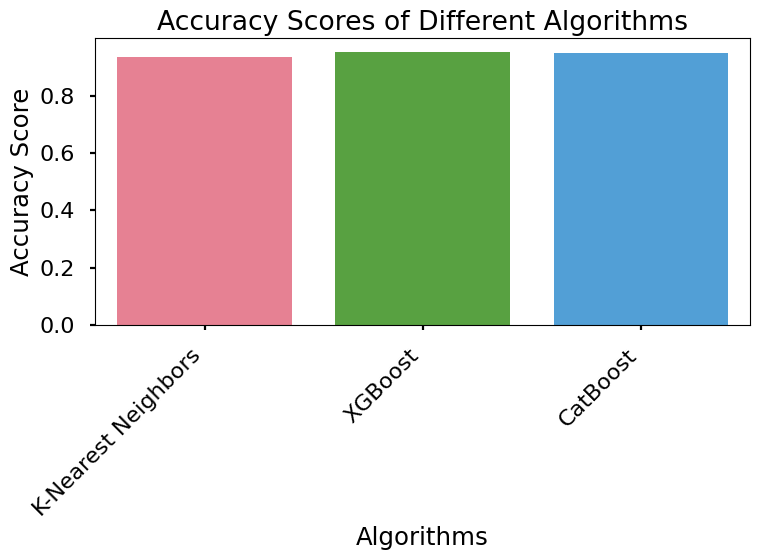

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Data
scores = [accuracy_lgb,  accuracy_xgb, accuracy_cb]
algorithms = ["K-Nearest Neighbors", "XGBoost", "CatBoost"]

# Set color palette
color_palette = sns.color_palette("husl", len(scores))

# Create bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=algorithms, y=scores, palette=color_palette)

# Add title and labels
plt.title('Accuracy Scores of Different Algorithms')
plt.xlabel('Algorithms')
plt.ylabel('Accuracy Score')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.ensemble import VotingRegressor

# Initialize VotingRegressor with the trained models
voting_model = VotingRegressor(estimators=[
    ('xgb', xgb_model),
    ('lgb', lgb_model),
    ('rf', rf_model)
])

# Fit the voting model on the training data
voting_model.fit(X_train, y_train)

# Predict on the test data
y_pred_voting = voting_model.predict(X_test)

# Calculate Mean Absolute Error (MAE)
mae_voting = mean_absolute_error(y_test, y_pred_voting)
print("Voting - Mean Absolute Error (MAE):", mae_voting)

# Calculate Mean Squared Error (MSE)
mse_voting = mean_squared_error(y_test, y_pred_voting)
print("Voting - Mean Squared Error (MSE):", mse_voting)

# Calculate R-squared
r_squared_voting = r2_score(y_test, y_pred_voting)
print("Voting - R-squared:", r_squared_voting)

# If needed, convert to classification problem and calculate accuracy
# For example, classify sales into two categories based on a threshold
threshold = 20000  # Example threshold
y_pred_class_voting = (y_pred_voting > threshold).astype(int)
y_test_class_voting = (y_test > threshold).astype(int)

# Calculate Accuracy
accuracy_voting = accuracy_score(y_test_class_voting, y_pred_class_voting)
print("Voting - Accuracy:", accuracy_voting)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1217
[LightGBM] [Info] Number of data points in the train set: 294148, number of used features: 12
[LightGBM] [Info] Start training from score 16152.408348
Voting - Mean Absolute Error (MAE): 2604.2202157835463
Voting - Mean Squared Error (MSE): 20819616.505382247
Voting - R-squared: 0.9574862062456214
Voting - Accuracy: 0.9597188729534205


In [ ]:
# Take the average of predictions from XGBoost, LightGBM, and Random Forest models
y_pred_avg = (y_pred_xgb + y_pred_lgb + y_pred_rf) / 3

# Calculate Mean Absolute Error (MAE) for the averaged predictions
mae_avg = mean_absolute_error(y_test, y_pred_avg)
print("Averaged Model - Mean Absolute Error (MAE):", mae_avg)

# Calculate Mean Squared Error (MSE) for the averaged predictions
mse_avg = mean_squared_error(y_test, y_pred_avg)
print("Averaged Model - Mean Squared Error (MSE):", mse_avg)

# Calculate R-squared for the averaged predictions
r_squared_avg = r2_score(y_test, y_pred_avg)
print("Averaged Model - R-squared:", r_squared_avg)

# If needed, convert to classification problem and calculate accuracy
# For example, classify sales into two categories based on a threshold
threshold = 20000  # Example threshold
y_pred_class_avg = (y_pred_avg > threshold).astype(int)
y_test_class_avg = (y_test > threshold).astype(int)

# Calculate Accuracy for the averaged predictions
accuracy_avg = accuracy_score(y_test_class_avg, y_pred_class_avg)
print("Averaged Model - Accuracy:", accuracy_avg)


Averaged Model - Mean Absolute Error (MAE): 2604.4902384577877
Averaged Model - Mean Squared Error (MSE): 20819811.285020232
Averaged Model - R-squared: 0.9574858085043203
Averaged Model - Accuracy: 0.9596474806447519
